In [23]:
import numpy as np
import pandas as pd
import os
import keras
from keras import layers, models, optimizers

from sklearn.metrics import confusion_matrix
from keras.applications import VGG16
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import matplotlib.pyplot as plt
import seaborn as sns

keras.__version__

'2.2.4'

Note: This is the version submitted via the Softuni web site. You do not have to train the models. Instead, you can use the saved training and validation data from the provided CSV files and you can also load the saved weights. Softuni does not allow me to upload the dataset and the full models. 

# Using Convolutional Neural Networks to Classify Images

by Tihomir Jilevski - tihomirj@gmail.com

Machine image classification is becoming more and more important as it quickly finds new applications. Currently it is used in medicine, self-driving cars, web search engines, document classification apps, automated quality control in manufacturing to name just a few. It literary finds new applications everyday.  

## Abstract 
In this paper we will train a convolutional neural network to classify images of cats and dogs. We will use a smaller dataset for several reasons:
* In practice more often than not we will work with limited data. 
* We will look into the limitations and the difficulties that the smaller size of the dataset imposes on the training. 
* We will try to find strategies that will help us overcome the limitations imposed by the small dataset

We start with a CNN model trained on a smaller dataset to establish the baseline. Our  CNN model is rather simple and is trained on 2000 images until reaching overfitting - training accuracy is 100% but validation accuracy is 75%.  Then, we train the same model on the full training set of 6000 images until overfitting - training accuracy again reaches 100% while validation accuracy slowly increases to 83%. We then perform data augmentation and regularization via dropout. We train the model longer and we manage to reach a validation accuracy of 89%. 

We also try a another strategy - using transfer learning. We use the convolutional base of a pretrained VGG16 model to extract features from our data set. These features are later passed to a fully connected network to perform the classification. This network is much faster to train as we only train the fully connected layers. What is more, it also performs marginally better - the validation accuracy is 90%. The winners of the Kaggle competition achieve 98.5% accuracy but they also train on the much larger dataset.

## Definition of helper functions

In [2]:
# This function plots the learning curves and the human performance
def plot_learning_curves(train_accuracy, validation_accuracy, train_loss, validation_loss):
    acc = train_accuracy
    val_acc = validation_accuracy
    loss = train_loss
    val_loss = validation_loss

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'go', label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc', color = "red")
    plt.axhline(y=0.995, label = 'Human performance', color = "orange", linestyle='-.')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'go', label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color = "red")
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.show()


## A short explanation of why CNNs are very useful in image classification

CNNs are a type of deep-learning neural networks, which are almost universally used in computer vision applications. 

The patterns they learn are translation invariant. After having learned a certain pattern in the upper-left corner of an image, a CNN can recognize it anywhere - for example in the bottom-right corner. A densely connected network will have to learn that same pattern anew if it appears in a new location.

CNNs can learn spatial hierarchies of patterns - the first convolution layer will learn small local patterns, a second convolution layer will learn larger patterns made of the features of the first layers, and so on.

All these characteristics of the CNNs enable them to use data more efficiently and learn increasingly complex images.

## Using convolutional neural networks on small datasets


In this paper we will show how to use convolutional neural networks (CNNs) in solving image classification problems. Particularly we will focus on those that involve small training datasets as these are the most common use cases.
In practice we do not have large datasets.  Very often the images we have available as a training set vary from several hundreds to several thousands. 
Here, we will classify images as "dogs" or "cats". We will use 8000 pictures of cats and dogs of them - 4000 cats and 4000 dogs. We will use the classic split 75% for training, 12.5% for validation and 12.5% for test:

* 6000 pictures for training (3000 cats and 3000 dogs)
* 1000 pictures for validation (500 cats and 500 dogs)
* 1000 pictures for final testing (500 cats and 500 dogs)

We will start with a small CNN without any regularization and data augmentation to set a base line. Then we will try to improve the model and its accuracy.

## Downloading data and preparing the datasets

We will use the data set from Kaggle which can be downloaded from here https://www.kaggle.com/c/dogs-vs-cats/data
This original dataset contains 25 000 images of dogs and cats (12 500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 3000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.
Each picture is a color JPG. The file name is `cat.{num}.jpg` for cat images and `dog.{num}.jpg`for dog images. The *`{num}`* part is the consecutive number of the image.
The structure of the dataset will be:
* `cats_and_dogs_small/train` - is the directory that contains the training set, it contains two subdirectories - `cats` with all training cat images and `dogs` with all training dog images. We select cat and dog images wih numbers from 1 to 3000 for each class. 
* `cats_and_dogs_small/validation` - is the directory that contains the validation set, it contains two subdirectories - `cats` with all validation cat images and `dogs` with all validation dog images. We select cat and dog images with numbers from 4001 to 4500 for each class. 
* `cats_and_dogs_small/test` - is the directory that contains the test set, it contains two subdirectories `cats` with all test cat images and `dogs` with all test dog images. We select cat and dog images with numbers from 3001 to 3500 for each class. 

Thus, we have 6000 images for training, 1000 images for validation and 1000 images for test, which represents the classical split 75% for training, 12.5% for validation and 12.5% for test.

In [3]:
# Directories for our training, validation and test splits
train_dir  = "cats_and_dogs_small/train"
train_cats_dir = "cats_and_dogs_small/train/cats"
train_dogs_dir = "cats_and_dogs_small/train/dogs"


validation_dir = "cats_and_dogs_small/validation"
validation_cats_dir = "cats_and_dogs_small/validation/cats"
validation_dogs_dir = "cats_and_dogs_small/validation/dogs"

test_dir = "cats_and_dogs_small/test"
test_cats_dir = "cats_and_dogs_small/test/cats"
test_dogs_dir = "cats_and_dogs_small/test/dogs"

To make sure we have the correct number of pictures in each directory, we will count them.

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('---------')
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('---------')
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 3000
total training dog images: 3000
---------
total validation cat images: 500
total validation dog images: 500
---------
total test cat images: 500
total test dog images: 500


We have indeed 6000 training images,  1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Building our classifier
We will start with a simple CNN just to establish the base line.

We will prepare below the train and the validation data generators.

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We will process the data in batches. Each batch contains 50 samples of images with the following dimensions 150 width x 150 height x 3 RGB channels. We will process one batch per step. Thus, we will make 120 steps to go through the whole training set (6000 images / 50 samples per batch). Respectively, we will make 20 steps to go through the whole validation set (1000 images / 50 samples per batch)

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    
    break

data batch shape: (50, 150, 150, 3)
labels batch shape: (50,)


Let us now see what our classes are

In [8]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

Cats will be labeled "0" and dogs will be labeled "1". 

## CNN architecture
We will choose a relatively simple architecture. Our convolutional neural network will contain four stacked pairs of convolutional and maxpooling layers. The first convolutional layer will have 32 filters of size 3 x 3 and activation ReLU (rectified linear unit). It will be followed a maxpooling layer with size 2 x 2. The next convolutional layer will have 64 filters 3 x 3. It will again be followed by a maxpooling layer.  The next two conv layers will have 128 filters 3 x 3. They will again be followed by maxpooling layers of size 2 x 2. For the max pooling we will use a stride of 2, which when not specified defaults to the size of the pool filter.   

After the last maxpooling layer we will add a flattening layer which will "flatten" the extracted features and will pass them as input to the first fully connected layer which has 512 units and uses activation ReLU. Then at the end comes the last fully connected layer that will classify  the outcomes which are binary - a picture can be either a "cat" or a "dog". The last fully connected layer has one unit and the activation is Sigmoid. Had the classification been more complex (with more classes), we would have used a dense layer with units equal to the number of classes and the activation would have been "softmax".

The main knobs to fiddle with and fine-tune here are the number of filters, the filter sizes, the learning rate, the stride and of course the architecture of the convolutional network.

When using a small number of images to train a CNN overfitting is a major concern. The model fails to generalize well because it has not seen enough features.

In [9]:
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten())

model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [11]:
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.adam(lr=0.001),
              metrics=['acc'])

The cell below will start the training. It is commented to prevent starting the training if there is no time. There is another cell below that loads preliminary saved weights. There is also an option to load the whole model.

In [ ]:
# history1 = model1.fit_generator(
#       train_generator,
#       steps_per_epoch=120,
#       epochs=30,
#       validation_data=validation_generator,
#       validation_steps=20)

In [ ]:
# saving the model and the weights
# model1.save('model_1.h5')
# model1.save_weights('model_1_weights.h5')

Uncomment the cell below to load the weights of the compiled model. It will load only the weights. The model must have been compiled above.

In [ ]:
#model1.load_weights('model_1_weights.h5')

Uncomment the cell below to load the entire model - architecture together with trained weights.

In [ ]:
#model1 = load_model('model_1.h5')

## Evaluation of the model

The human  error for classifying pictures of cats and dogs is about 0.5%. It is a good proxy for the Bayes (intrinsic) error. We will use the following indicators for the quality of our model:
* train accuracy
* validation accuracy
* avoidable bias - this is the difference between the train set error and the human error, which we use as a proxy for the intrinsic error
* variance - this is the difference between the train set error and the validation set error

We will define below a function that will collect into a dataframe important diagnostic indicators for our model such as - human error, train accuracy, validation accuracy, train loss, validation loss, avoidable bias and variance. This dataframe can later be saved as a csv file for future diagnostics.

In [ ]:
def history_to_dataframe(history):
    
    human_error = np.array([0.005]*len(history.epoch)) # an array containing the human error for each epoch
    
    acc = np.array(history.history['acc'])
    
    val_acc = np.array(history.history['val_acc'])
    
    loss = np.array(history.history['loss'])
    
    val_loss = np.array(history.history['val_loss'])
    
    avoidable_bias = 1-acc-human_error # the avoidable bias is train set error less human error
    
    model_variance = acc-val_acc # the variance is the validation set error minus the train set error

    train_data_model = {"train_accuracy":acc,
                        "validation_accuracy":val_acc,
                        "train_loss":loss,
                        "validation_loss":val_loss,
                        "human_error":human_error,
                        "avoidable_bias":avoidable_bias,
                        "variance":model_variance}
    
    return pd.DataFrame(train_data_model)


Let us have a look at the last data for accuracy and validation accuracy of the model we have just trained.

If the model has not been just trained the cell below will throw an error because `history1` is not defined. Instead, please load the saved CSV file `history_model_1_100epochs_backup.csv` (trained  100 epochs) or `history_model_1_30epochs_backup.csv` (trained 30 epochs) in the cells that follow further below.

**If using saved data please skip the next 4 cells.**

In [ ]:
# Please uncomment if the model has just been trained to use the current data
#train_data_model_1 = history_to_dataframe(history1)

In [ ]:
# Please uncomment if the model has just been trained to see current results
#train_data_model_1.tail()

Let us plot the most important performance indicators - train and validation indicators for accuracy and loss.

In [ ]:
# Please uncomment if the model has just been trained
# plot_learning_curves(train_data_model_1["train_accuracy"],
#                      train_data_model_1["validation_accuracy"],
#                      train_data_model_1["train_loss"],
#                      train_data_model_1["validation_loss"])

We will now save the dataframe as a csv file for future references and comparisons.

In [ ]:
# Please uncomment if the model has just been trained
#train_data_model_1.to_csv("history_model_1_30epochs.csv")

If we do not have time to train the model, we can load the learning data from a file. The file contains data from the previously run training with 100 epochs.  What we see is that after about 30 epochs the model is not learning. That is why we currently train it with 30 epochs. 

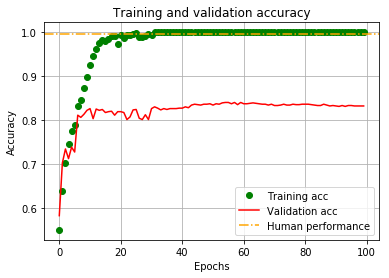

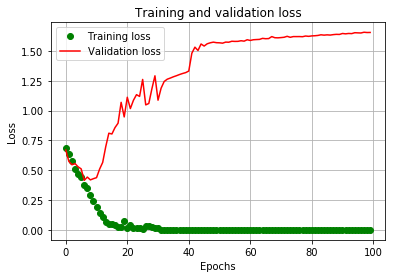

In [12]:
data_history_model_1 = pd.read_csv("history_model_1_100epochs_backup.csv")
#data_history_model_1 = pd.read_csv("history_model_1_30epochs_backup.csv")
plot_learning_curves(data_history_model_1["train_accuracy"],
                     data_history_model_1["validation_accuracy"],
                     data_history_model_1["train_loss"],
                     data_history_model_1["validation_loss"])

In the cell below we see the saved dataframe for 100 epochs with some important diagnostic indicators for our model such as - human error, train accuracy, validation accuracy, train loss, validation loss, avoidable bias and variance.

In [13]:
data_history_model_1.tail()

,Unnamed: 0,train_accuracy,validation_accuracy,train_loss,validation_loss,human_error,avoidable_bias,variance
95,95,1.0,0.833,2.976837e-07,1.650576,0.005,-0.005,0.167
96,96,1.0,0.832,2.901946e-07,1.649516,0.005,-0.005,0.168
97,97,1.0,0.832,2.784523e-07,1.655731,0.005,-0.005,0.168
98,98,1.0,0.832,2.716952e-07,1.653411,0.005,-0.005,0.168
99,99,1.0,0.832,2.641665e-07,1.653976,0.005,-0.005,0.168


These plots are characteristic of overfitting. Our training accuracy increases over time, until it reaches 100%, while our validation accuracy stalls at 83% for many epochs. Our validation loss reaches its minimum after about 10 epochs and then starts to increase, while the training loss keeps decreasing until it reaches 0. What we see here is that the train set accuracy surpasses human performance while the validation accuracy is not improving and there is relatively big difference between the train set error and the validation error. Our biggest concern in this case is over-fitting.

Let us compare the learning curves from above with the ones from the same model that was trained on 2000 pictures - 3 times smaller train set.

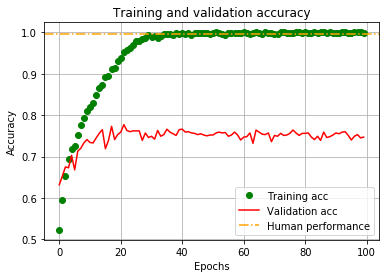

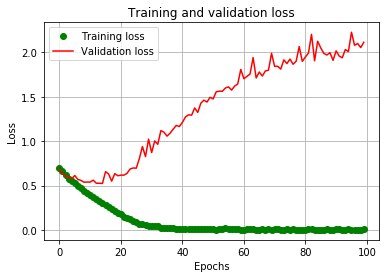

In [14]:
# Training and validation data for the same model trained on 2000 pictures
data_history_model_1 = pd.read_csv("history_model_1_100epochs_2000_backup.csv")

plot_learning_curves(data_history_model_1["train_accuracy"],
                     data_history_model_1["validation_accuracy"],
                     data_history_model_1["train_loss"],
                     data_history_model_1["validation_loss"])

In [15]:
# Training and validation data for the same model trained on 2000 pictures
data_history_model_1.tail()

,Unnamed: 0,train_accuracy,validation_accuracy,train_loss,validation_loss,human_error,avoidable_bias,variance
95,95,0.9990,0.740,0.003300,2.227076,0.005,-0.0040,0.2590
96,96,1.0000,0.749,0.000267,2.080139,0.005,-0.0050,0.2510
97,97,0.9995,0.753,0.004275,2.100087,0.005,-0.0045,0.2465
98,98,0.9995,0.745,0.001783,2.054397,0.005,-0.0045,0.2545
99,99,0.9980,0.747,0.006551,2.113519,0.005,-0.0030,0.2510


We have trained the above model with 2000 pictures (3 times smaller dataset) and the validation accuracy we reached was 75%. By adding 4000 new pictures to the training set we improved the validation accuracy from 76% to 83% and helped reduce the variance of the model but this is still not enough. What if we don't have more pictures? What shall we do to further reduce the overfitting and improve the validation accuracy if we don't have new pictures for training. Read on...

## Improving the model
We will do some improvements to our model that have to deal with the overfitting. 
One of the reasons for the overfitting is the small size of the training set. With just a few data we are not able to train a model so that it can generalize well. Data augmentation generates more training data from existing training samples, by "augmenting" the samples via a number of random transformations that produce believable-looking images. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, data augmentation is done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Augmentation is performed in real time.

In [16]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Let us see some augmented pictures of a random cat from our train set.

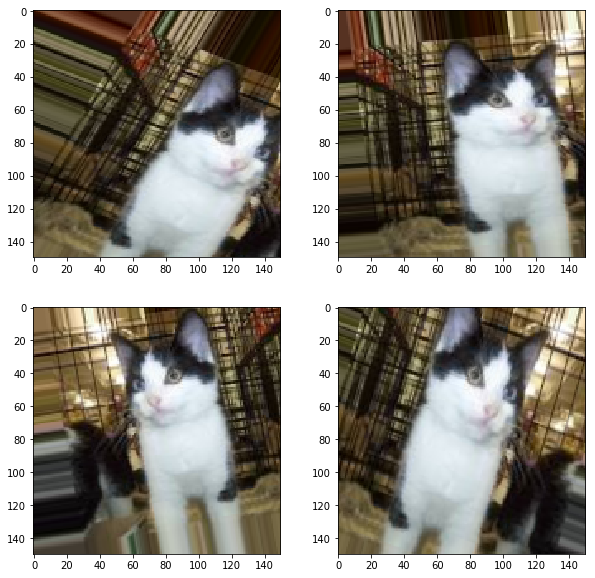

In [17]:
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0

plt.figure(figsize=(10,10))

for batch in datagen.flow(x, batch_size=1):
    
    plt.subplot(2,2,i+1)   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Although we have done data augmentation, the images are still heavily correlated because we have only remixed the existing information. We have not produced new information. Therefore, we will add a dropout layer right after the flatenning layer to further fight over-fitting. We will start with a dropout rate = 0.3 and if necessary we will adjust it.

In [18]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))

model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))

model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())

model2.add(layers.Dropout(0.3))

model2.add(layers.Dense(512, activation='relu'))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Now we will define the data generators for training with data augmentation and validation without data augmentation.

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')



Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's train our network using data augmentation and dropout.

The cell below will start the training of the improved model. It takes about 90 minutes. In the next cells there is an option to load the same trained model, or only load the weights.

In [ ]:
# history2 = model2.fit_generator(
#       train_generator,
#       steps_per_epoch=120,
#       epochs=100,
#       validation_data=validation_generator,
#      validation_steps=20)

Uncomment the cell below to save the model and the weights.

In [ ]:
#saving the model2 and the weights
#model2.save('model_2.h5')
#model2.save_weights('model_2_weights_150.h5')

Uncomment the cell below to load the saved weights of the compiled model. It will load only the weights. The model must have been compiled above.

In [ ]:
#model2.load_weights('model_2_weights.h5')

To load the whole model - architecture and weights please uncomment the cell below

In [20]:
model2 = load_model('model_2_backup.h5')

If the model has not been just trained the cell below will throw an error because `history2` is not defined. 

Instead, please load the saved CSV file `history_model_2_100epochs_backup.csv` (trained  100 epochs) in the cells that follow further below.

In [ ]:
#train_data_model_2 = history_to_dataframe(history2)

In [ ]:
#train_data_model_2.tail()

In [ ]:
# plot_learning_curves(train_data_model_2["train_accuracy"],
#                      train_data_model_2["validation_accuracy"],
#                      train_data_model_2["train_loss"],
#                      train_data_model_2["validation_loss"])

We will now save the dataframe as a csv file for future references and comparisons.

In [ ]:
#train_data_model_2.to_csv("history_model_2_100epochs.csv")

If we do not have time to train the model, we can load the learning data from a file. Just uncomment the cell below.

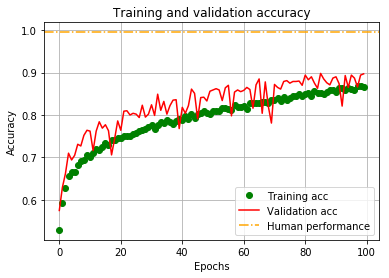

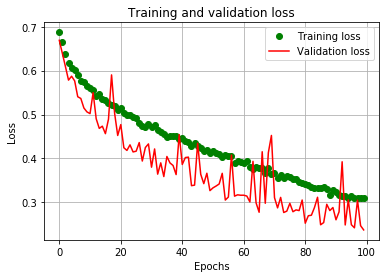

In [21]:
data_history_model_2 = pd.read_csv("history_model_2_100epochs_backup.csv")
plot_learning_curves(data_history_model_2["train_accuracy"],
                     data_history_model_2["validation_accuracy"],
                     data_history_model_2["train_loss"],
                     data_history_model_2["validation_loss"])

Please uncomment the cell below to see the saved dataframe with some important diagnostic indicators for our model such as - human error, train accuracy, validation accuracy, train loss, validation loss, avoidable bias and variance 

In [22]:
data_history_model_2.tail()

,Unnamed: 0,train_accuracy,validation_accuracy,train_loss,validation_loss,human_error,avoidable_bias,variance
95,95,0.860667,0.894,0.315036,0.248919,0.005,0.134333,-0.033333
96,96,0.859500,0.887,0.308848,0.241848,0.005,0.135500,-0.027500
97,97,0.867500,0.866,0.310357,0.304789,0.005,0.127500,0.001500
98,98,0.868167,0.894,0.310076,0.246733,0.005,0.126833,-0.025833
99,99,0.865167,0.897,0.308660,0.237048,0.005,0.129833,-0.031833


What we notice first is that the validation accuracy is a bit higher than the training accuracy. This is due to the fact that we are augmenting the train set but not the validation set and the variance of the train set is higher.

We see that after 100 epochs the training and the validation accuracy are still increasing and the loss functions are decreasing. They have not yet reached a plateau. We can continue training to see where the training and the validations accuracies and loss functions will go but I doubt that the validation accuracy will go much closer to the human performance.

What we have seen is that the variance of the model has declined. The validation accuracy has improved from about 83% to about 89%. We are no longer over fitting. Now our problem is that we are for sure under fitting. The accuracy of the model is far from the human accuracy and the avoidable bias has increased.

To combat this under fitting we can try to decrease the regularization, fine tune the hyper parameters of the CNN (number of filters per layer, size of filters, stride, number of units per layer, number of layers). Instead of using Dropout layer we can try to use Batch normalization between some of the convolution and the Activation layers. Batch normalization is another method to regularize a convolutional network. On top of a regularizing effect, batch normalization also gives the convolutional network a resistance to vanishing gradient during training. This can result in better performance.

## Feature extraction
Another approach to deep learning on small image datasets is to use a pre-trained network. A pre-trained network is a saved network previously trained on a large dataset, typically on a large-scale image classification task. We can use for example VGG16 for feature extraction. We take the convolutional base without the fully connected layer. We extract the features and we pass them to a fully connected layer made by us for classification.

In [24]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The output extracted features of a single image are 4 x 4 x 512 = 8192. Below we define a function that will use the convolutional base to extract the features from the datasets. 

In [26]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

We extract the features and the labels from the train set

In [27]:
train_features, train_labels = extract_features(train_dir, 6000)

Found 6000 images belonging to 2 classes.


In [28]:
train_features.shape

(6000, 4, 4, 512)

In [29]:
train_labels.shape

(6000,)

We extract the features and labels from the validation set

In [30]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


We extract the features and labels from the test set

In [31]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


We reshape the sets to dimensions *number of samples* x 8192 so that we can feed them to the dense layer.

In [32]:
train_features = np.reshape(train_features, (6000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [33]:
train_features.shape

(6000, 8192)

In [34]:
validation_features.shape

(1000, 8192)

In [35]:
model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [36]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


The next cell will start the training. Further down below there are cells where the pre-trained model or its weights can be loaded.

In [ ]:
# Remove comments to start training

# history3 = model3.fit(train_features, train_labels,
#                     epochs=30,
#                     batch_size=20,
#                     validation_data=(validation_features, validation_labels))

Please uncomment below to save the model and its weights.

In [ ]:
# saving the model2 and the weights
# model3.save('model_3.h5')
# model3.save_weights('model_3_weights.h5')

The next 2 cells will throw errors if run without prior training of the last model because `history3` is not defined.

In [ ]:
#Uncomment if model3 has just been trained and history3 is defined
#train_data_model_3 = history_to_dataframe(history3)

In [ ]:
#Uncomment if model3 has just been trained and history3 is defined
# plot_learning_curves(train_data_model_3["train_accuracy"],
#                      train_data_model_3["validation_accuracy"],
#                      train_data_model_3["train_loss"],
#                      train_data_model_3["validation_loss"])

In [ ]:
#train_data_model_3.to_csv("history_model_3_30epochs.csv")

If we do not have time to train the model, we can load the learning data from a file. Just load the cell below.


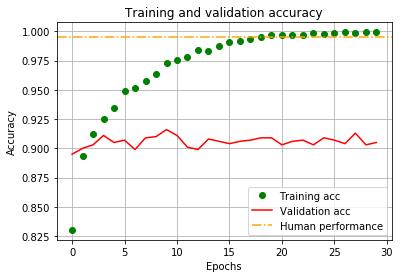

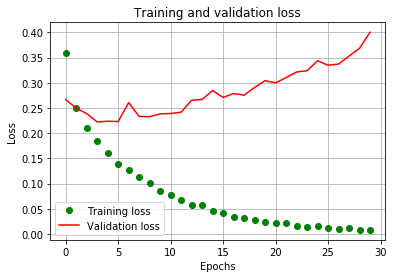

In [37]:
data_history_model_2 = pd.read_csv("history_model_3_30epochs_backup.csv")
plot_learning_curves(data_history_model_2["train_accuracy"],
                     data_history_model_2["validation_accuracy"],
                     data_history_model_2["train_loss"],
                     data_history_model_2["validation_loss"])

With the feature extraction via the convolutional base and the addition of our fully connected layer we have achieved a marginally better validation accuracy than both of our models. We used the training set without data augmentation. Again the model is overfitting. We can try some regularization and may be again data-augmentation.

## Testing the  model

The ultimate test for a model is when it is shown images that it has never seen before. We will use our second model because it is our brainchild and we like it very much. The best results in the Kaggle competition are 98.5%. With our validation score of 89.7% we are going to be around 74th position.

In [38]:
# generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary',
        shuffle = False)

Found 1000 images belonging to 2 classes.


The sigmoid function will return probabilities for the class between 0 and 1.

In [39]:
probabilities = model2.predict_generator(test_generator, 1000)

Now we have to turn the probabilities into class pedictions and compare them with the true classes. We use the confussion matrix.

In [40]:
y_true = test_generator.classes

y_pred = probabilities > 0.5 # we turn the probabilities into class predictions

cm = confusion_matrix(y_true, y_pred)

Just to remind the classes that we predict are:

In [41]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [42]:
cm

array([[436,  64],
       [ 38, 462]], dtype=int64)

In [43]:
accuracy = (cm[0][0]+cm[1][1])/cm.sum()

In [44]:
accuracy

0.898

In [45]:
# plots the confusion matrix
def draw_confusion_marix(y_ts, predictions, score):
    
    cm = confusion_matrix(y_ts, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0:.1%}'.format(score)
    plt.title(all_sample_title, size = 15);

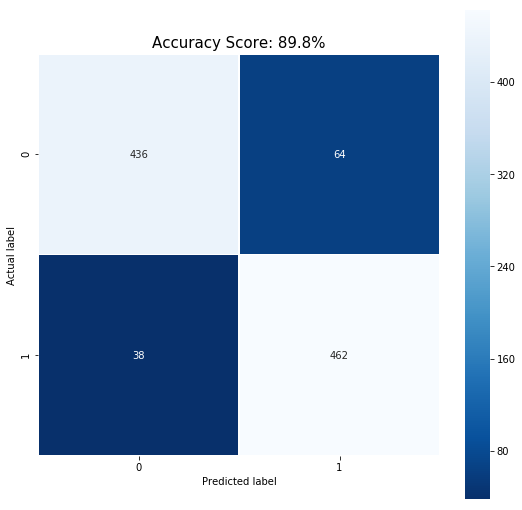

In [46]:
draw_confusion_marix(y_true, y_pred, accuracy)

## Conclusion

Our model achieved almost 90% accuracy on the test set (89.8% test accuracy to be more specific)- 436 cats were correctly classified as cats and 462 dogs were correctly classified as dogs. Only 38 dogs were mistakenly classified as cats and 64 cats were mistakenly classified as dogs. May be we can improve the results by training the model on even more images, training it longer and using batch normalization to improve the learning. 

## Resources:

1. Deep learning with Python - Francois Chollet
2. Deep learning for computer vision with Python - Dr. Adrian Rosebrock